# Reproduce Paper: Efficient evolution of human antibodies from general protein language models
https://www-nature-com.sire.ub.edu/articles/s41587-023-01763-2

In [2]:
from transformers import AutoTokenizer, EsmForMaskedLM, pipeline, AutoModelForCausalLM
import torch
import pandas as pd
import itertools
from datasets import Dataset
import seaborn as sns

In [3]:
tokenizer_args = {}
tokenizer_args["padding"] = True
tokenizer_args["truncation"] = True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name, **tokenizer_args)
model = EsmForMaskedLM.from_pretrained(model_name, low_cpu_mem_usage=True, offload_folder="offload", device_map=device, 
                                       torch_dtype=torch.float16)

Using cpu device


In [5]:
model.eval()

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_a

In [5]:
protein_sequence = "MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE"

In [23]:
def masked_marginal(positions, input_ids, tokenizer, model):
	all_prob = {}
	for x in positions:
		masked_input_ids = input_ids.clone()
  # The plus + makes sure we are assigning the correct positions to the correct index (since CLS is at the begining of teh position)
		masked_input_ids[0, x+1] = tokenizer.mask_token_id
		with torch.no_grad():
			output = model(masked_input_ids).logits # to remove the probabilities of the tokens [CLS] and [SEP]
		probabilities = torch.nn.functional.softmax(output[0, x+1], dim=0)
		all_prob[x] = torch.log(probabilities)
	return all_prob

def wild_marginal(positions, input_ids, tokenizer, model):
	all_prob = {}
	with torch.no_grad():
		output = model(input_ids).logits
	for x in positions:
     # softmaxing the probabilities of the correct positions -> so it is shape 33 the probabilities
		probabilities = torch.nn.functional.softmax(output[0, x+1], dim=0)
		all_prob[x] = torch.log(probabilities)
	return all_prob

def get_probabilities(protein_sequence, model, tokenizer, positions=(), 
                      strategy=masked_marginal):
    # Encode the protein sequence
    input_ids = tokenizer.encode(protein_sequence, return_tensors="pt") # it will add a cls and eos tokens, so the lenght is less 
    # sequence_length = input_ids.shape[1] - 2 
    # List of amino acids
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    if not isinstance(amino_acids, str):
        raise TypeError("amino_acids should be a string")
    aa_ids = {aa: tokenizer.convert_tokens_to_ids(aa) for aa in amino_acids}
    if not aa_ids:
        raise ValueError("Could not convert tokens to ids")
    prob_mt = {}
    # Get the probabilities	
    all_prob = strategy(positions, input_ids, tokenizer, model)
    if not all_prob:
        raise ValueError("Could not get the probabilities")
    if not positions:
        positions = range(input_ids.shape[1]-2) # -2 to remove the CLS and EOS tokens
        # This will get he probabilities of all the positions in the sequence
        
    for pos in positions:
        wt_residue_id = input_ids[0, pos+1].item()
        wt_token = tokenizer.convert_ids_to_tokens(wt_residue_id)
        # Get the probability of the wild type residue
        prob_wt = all_prob[pos][wt_residue_id].item()
        # Get the probability of the mutant residue relative to the wild type residue
        prob_mt[f"{wt_token}{pos}"] = {f"{key}": all_prob[pos][value].item() - prob_wt for key, value in aa_ids.items()}
    return pd.DataFrame(prob_mt).T

def filter_probabilities_by_alpha(probability, alpha):
	# Filter the probabilities
	filtered_prob = {}
	for pos, probs in probability.items():
		filtered_prob[pos] = {aa: prob for aa, prob in probs.items() if prob > alpha}
	return filtered_prob


def filter_probabilities_by_set(probability, aa_set):
	# Filter the probabilities
	filtered_prob = {}
	for aa in aa_set:
		print(aa)
		filtered_prob[aa[:2]] = {}
		for mut, probs in probability[aa[:2]].items():
			if mut == aa[-1]:
				filtered_prob[aa[:2]][mut] = probs
	return filtered_prob

def return_set(probabilities):
	# Return the set of the probabilities
	prob_set = []
	for prob in probabilities:
		proba = []
		for key, value in prob.items():
			proba.extend([f"{key}{k}" for k in value.keys()])
		prob_set.append(proba)
	prob = set(prob_set[0]).intersection(*prob_set[1:])
	return prob

def filter_by_k(probabilities, k):
	# Filter the probability based on how many models agree
	sets = list(itertools.combinations(probabilities, k))
	all_sets = [return_set(comb_probabilities) for comb_probabilities in sets]
	all_sets = all_sets[0].union(*all_sets[1:])
	new_probabilities = [filter_probabilities_by_set(prob, all_sets) for prob in probabilities]
	return new_probabilities


In [24]:
def count_vote(probabilities):
	# Return the set of the probabilities
	model_count = {}
	model_names = {}
	for model_name, prob in probabilities.items():
		for key, value in prob.items():
			aa = [f"{key}{k}" for k in value.keys()]
			for a in aa:
				if a in model_count:
					model_count[a] += 1
					model_names[a].append(model_name)
				else:
					model_count[a] = 0
					model_names[a] = []
	return model_count, model_names

In [26]:
input_ids = tokenizer.encode(protein_sequence, return_tensors="pt") # it will add a cls and eos tokens, so the lenght is less 
# sequence_length = input_ids.shape[1] - 2 
# List of amino acids
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_ids = {aa: tokenizer.convert_tokens_to_ids(aa) for aa in amino_acids}
prob_mt = {}
positions = 2 # zero indexed
masked_input_ids = input_ids.clone()
masked_input_ids[0, positions + 1] = tokenizer.mask_token_id
with torch.no_grad():
    output = model(masked_input_ids).logits # to remove the probabilities of the tokens [CLS] and [SEP] 

In [27]:
probabilities = torch.nn.functional.softmax(output[0, positions+1], dim=0)
log_prob = torch.log(probabilities)
wt_residue_id = input_ids[0, positions+1].item()
wt_token = tokenizer.convert_ids_to_tokens(wt_residue_id)
# Get the probability of the wild type residue
prob_wt = log_prob[wt_residue_id].item()
# Get the probability of the mutant residue relative to the wild type residue
prob_mt[f"{wt_token}{positions}"] = {f"{key}": log_prob[value].item() - prob_wt 
                                for key, value in aa_ids.items()}

In [8]:
pro = pd.DataFrame(prob_mt).T
a = {"seq1": pro, "seq2": pro, "seq3": pro}
u = pd.concat(a)

In [10]:
dat = Dataset.from_dict({"protein_sequence": [protein_sequence, protein_sequence]})
tok = dat.map(lambda examples: tokenizer(examples["protein_sequence"], return_tensors="np"), batched=True)
tok.set_format(type="torch", columns=["input_ids", "attention_mask"])

Map: 100%|██████████| 2/2 [00:00<00:00, 534.03 examples/s]


In [ ]:
a = get_probabilities(protein_sequence, model, tokenizer, positions=range(0, 10))

: 

In [ ]:
u = pd.read_csv("test.csv", index_col=[0,1])


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
P2,0.295406,-2.850163,0.606348,1.052304,-0.956331,-0.088888,-1.368847,0.174118,0.886782,0.083619,-1.641879,0.449908,0.0,-0.252202,-0.313501,0.748899,0.660977,0.073754,-3.000461,-1.120543


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForMaskedLM.from_pretrained(model_name)
# Encode the protein sequence
input_ids = tokenizer.encode(protein_sequence, return_tensors="pt") # it will add a cls and eos tokens, so the lenght is less 
# sequence_length = input_ids.shape[1] - 2 
# Get the probabilities	
with torch.no_grad():
    output = model(input_ids).logits[0,1:-1]

probabilities = torch.nn.functional.softmax(output, dim=1)
val = 0
for num, i in enumerate(input_ids[0,1:-1]):
    val += probabilities[num][i]
val.item()


75.0037612915039

In [ ]:
def wild_marginal(positions, input_ids, tokenizer, model):
	all_prob = []
	with torch.no_grad():
		output = model(input_ids).logits
	for x in positions:
		probabilities = torch.nn.functional.softmax(output[0, x+1], dim=0)
		all_prob.append(probabilities)
	return all_prob

In [30]:
input_ids = tokenizer.encode(protein_sequence, return_tensors="pt") # it will add a cls and eos tokens, so the lenght is less 
tokenizer.decode(input_ids[0])

'E'

In [36]:

sequence_length = input_ids.shape[1] - 2 
# List of amino acids
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_ids = {aa: tokenizer.convert_tokens_to_ids(aa) for aa in amino_acids}
masked_input_ids = input_ids.clone()
masked_input_ids[0,56] = tokenizer.mask_token_id
with torch.no_grad():
    output = model(masked_input_ids).logits
    newoutput = model(input_ids).logits

In [64]:
all_prob = []
for x in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
	masked_input_ids = input_ids.clone()
	masked_input_ids[0, x+1] = tokenizer.mask_token_id
	with torch.no_grad():
		output = model(masked_input_ids).logits
	wt_residue_id = input_ids[0, x+1].item()
	wt_token = tokenizer.convert_ids_to_tokens(wt_residue_id)
	# Get the probability of the wild type residue
	probabilities = torch.nn.functional.softmax(output[0, x+1], dim=-1)
	all_prob.append(probabilities)


In [46]:
probabilities = torch.nn.functional.softmax(output[0, 56], dim=0)
log_probabilities = torch.log(probabilities)
log_probabilities

tensor([-16.7804, -27.3554, -15.7982, -27.3520,  -1.4277,  -2.5076,  -3.9805,
         -1.9887,  -4.3450,  -3.8944,  -3.6909,  -4.1550,  -1.9134,  -4.8577,
         -4.9729,  -3.4737,  -4.2161,  -4.5330,  -2.4678,  -2.4993,  -3.5960,
         -4.5091,  -3.9432,  -5.1766, -11.6180, -15.6090, -15.8708, -16.4083,
        -19.7412, -20.0578, -20.1161, -20.1449, -27.3477])

In [48]:
probabilities.shape

torch.Size([33])

In [42]:
wt_residue = input_ids[0, 56].item()

log_prob_wt = log_probabilities[wt_residue].item()

In [53]:
prob_wt = probabilities[wt_residue].item()
# Get the probability of the mutant residue
prob_mt = {f"E56{key}": probabilities[value].item()/prob_wt for key, value in aa_ids.items()}
prob_mt

{'E56A': 4.001879542035948,
 'E56C': 0.2774215940895632,
 'E56D': 0.38165176240465715,
 'E56E': 1.0,
 'E56F': 4.164444006026979,
 'E56G': 0.9174956996554051,
 'E56H': 0.5408050497639408,
 'E56I': 7.24976954106049,
 'E56K': 1.5230791107844535,
 'E56L': 11.783465044635921,
 'E56M': 1.3477541668824693,
 'E56N': 0.5280566944547288,
 'E56P': 0.34012259939748507,
 'E56Q': 0.7249081595733019,
 'E56R': 1.2257103964296387,
 'E56S': 0.6372239090923898,
 'E56T': 0.770610221597457,
 'E56V': 6.724243731397887,
 'E56W': 0.9524152847213364,
 'E56Y': 4.035606249303408}

In [91]:
prob_mt["E56L"] / prob_mt["E56I"]

1.625357189342083

In [117]:
pipe = pipeline(task="fill-mask", model=model_name, tokenizer=model_name, top_k=20)

def use_pipe_marginal(pipe, sequence, positions, tokenizer):
	seq = []
	for pos in positions:
		sequence = sequence[:pos] + tokenizer.mask_token + sequence[pos+1:]
		seq.append(sequence)
	return pipe(seq)


def parse_pipe_output(output, sequence, positions):
	all_proba = {}
	for num, pos in enumerate(positions):
		wild = sequence[pos]
		all_proba[f"{wild}{pos}"] = {x["token_str"]: x["score"] for x in output[num]}
		all_proba[f"{wild}{pos}"] = {k: v / all_proba[f"{wild}{pos}"][wild] for k, v in all_proba[f"{wild}{pos}"].items()}
	return pd.DataFrame(all_proba).T

## Test mask

In [1]:
from BioML.applications import suggest

In [33]:
sug = suggest.SuggestMutations()

In [42]:
stra = {"masked_marginal": suggest.masked_marginal, "wild_marginal": suggest.wild_marginal}
sequences = sug.read_fasta("/home/ruite/Projects/Oxipro/TMM/mfmo.fasta")
input_ids = sug.tokenizer.encode(sequences["tr|Q83XK4|Q83XK4_9GAMM"], return_tensors="pt")
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_ids = {aa: sug.tokenizer.convert_tokens_to_ids(aa) for aa in amino_acids}
prob_mt = {}

positions = range(input_ids.shape[1]-2) # -2 to remove the CLS and EOS tokens
all_prob = stra["masked_marginal"](positions, input_ids, sug.tokenizer, sug.model)

In [2]:
from pathlib import Path
save_path = Path("/home/ruite/Projects/Oxipro/TMM/suggestions.csv")

In [ ]:
for pos in positions:
    wt_residue_id = input_ids[0, pos+1].item()
    wt_token = sug.tokenizer.convert_ids_to_tokens(wt_residue_id)
    # Get the probability of the wild type residue
    prob_wt = all_prob[pos][wt_residue_id].item()
    # Get the probability of the mutant residue relative to the wild type residue
    prob_mt[f"{wt_token}{pos}"] = {f"{key}": all_prob[pos][value].item() - prob_wt for key, value in aa_ids.items()}


suggestions = pd.DataFrame(prob_mt).T

suggestions.to_csv(save_path)

In [5]:
import pandas as pd
suggestions = pd.read_csv(save_path, index_col=[0])

In [22]:
plot_path = save_path.parent / "heatmap" / f"mfmo_suggestions.png"
plot_path.parent.mkdir(parents=True, exist_ok=True)
#sug.plot_heatmap(suggestions[suggestions>0], plot_path=plot_path)

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_heatmap(suggestions: pd.DataFrame, plot_path: str | Path="suggestions.png"):
    """
    Plot the heatmap of the suggestions.
    
    Parameters
    ----------
    suggestions : pd.DataFrame
        The suggestions to plot.
    plot_path : str | Path, optional
        The path to save the plot.
    """
    for x in range(0, suggestions.shape[0], 100):
        plt.figure(figsize=(20, 20))
        plt.tick_params(axis="x", labelsize=10, labelbottom=True, labeltop=True, bottom=True, top=True)
        sns.heatmap(suggestions.iloc[x:x+100], cmap="coolwarm", annot=True, fmt=".2f")
        plt.title("Mutations Suggestions")
        plt.savefig(plot_path.parent/f"{plot_path.stem}_{x}.png", transparent=False, dpi=600)
        plt.close()

In [ ]:
plot_heatmap(suggestions[suggestions>0.5], plot_path=plot_path)

<Axes: >

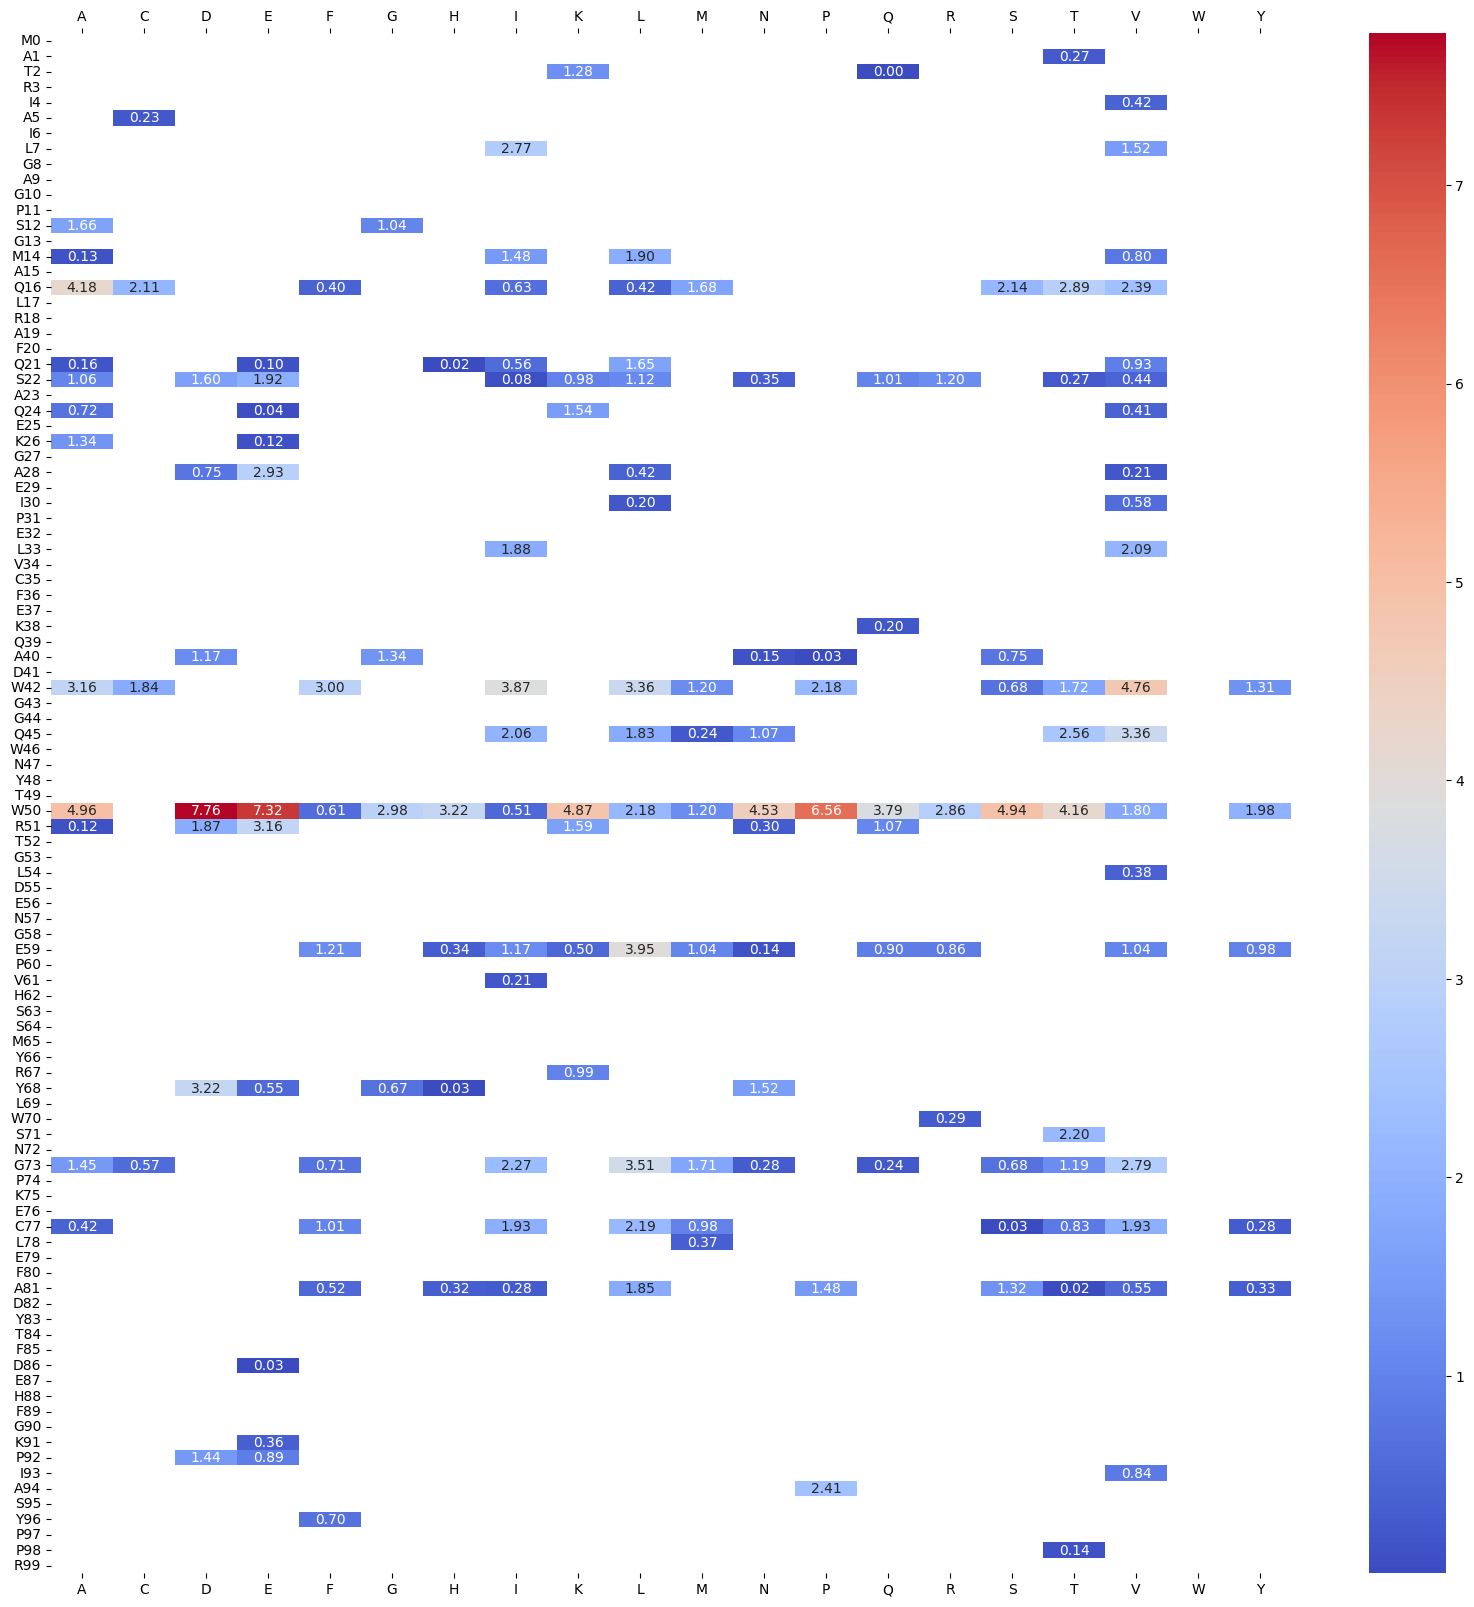

In [ ]:

plt.figure(figsize=(20, 20))
plt.tick_params(axis="x", labelsize=10, labelbottom=True, labeltop=True, bottom=True, top=True)
sns.heatmap(suggestions[suggestions>0.5].iloc[0:100], cmap="coolwarm", annot=True, fmt=".2f")